### Installation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("chromVAR", version = "3.8")
# BiocManager::install("motifmatchr", version = "3.8")
# BiocManager::install("BSgenome.Mmusculus.UCSC.mm9", version = "3.8")
# BiocManager::install("JASPAR2016", version = "3.8")

###  Import packages

In [2]:
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
library('JASPAR2016')
library(BSgenome.Mmusculus.UCSC.mm9)


Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, r

In [3]:
packageVersion("chromVAR")

[1] ‘1.4.1’

In [4]:
register(MulticoreParam(10))

### Obtain Feature Matrix

In [5]:
start_time <- Sys.time()

In [6]:
set.seed(2019)

In [7]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [8]:
head(metadata)

,label
TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC,BoneMarrow
TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC,BoneMarrow
ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT,BoneMarrow
TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC,BoneMarrow
ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT,BoneMarrow
ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG,BoneMarrow


In [9]:
peakfile <- "../../input/combined.sorted.merged.bed"
peaks <- getPeaks(peakfile, sort_peaks = TRUE)

Warning message in getPeaks(peakfile, sort_peaks = TRUE):
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”Peaks sorted


`width=500` will cause the error: Error in loadFUN(x, seqname, ranges): trying to load regions beyond the boundaries of non-circular sequence "chr17"

In [10]:
peaks <- resize(peaks, width = 450, fix = "center")

In [11]:
bamfile <- list.files(path = "../../input/sc-bams_nodup/", pattern = "\\.bam$")

In [12]:
length(bamfile)

[1] 12178

In [13]:
head(bamfile)

[1] "BoneMarrow_62016.AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT.header.bam"
[2] "BoneMarrow_62016.AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC.header.bam"
[3] "BoneMarrow_62016.AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC.header.bam"
[4] "BoneMarrow_62016.AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC.header.bam"
[5] "BoneMarrow_62016.AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC.header.bam"
[6] "BoneMarrow_62016.AGCGATAGAGTTGAATCAAAGCTAGGTTCCTATCCT.header.bam"

In [14]:
cellnames <- sapply(strsplit(bamfile,'.',fixed = TRUE), "[[", 2)

In [15]:
sum(cellnames == rownames(metadata))

[1] 20

In [16]:
ix = match(rownames(metadata),cellnames)
bamfile = bamfile[ix]
cellnames = cellnames[ix]

In [17]:
sum(cellnames == rownames(metadata))

[1] 12178

In [18]:
head(paste0("../../input/sc-bams_nodup/",bamfile))

[1] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam"
[2] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam"
[3] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam"
[4] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam"
[5] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam"
[6] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG.header.bam"

In [ ]:
fragment_counts <- getCounts(paste0("../../input/sc-bams_nodup/",bamfile), 
                             peaks, 
                             paired = TRUE, 
                             by_rg = FALSE, 
                             format = "bam", 
                             colData = data.frame(cellid = cellnames,
                                                  label = metadata$label))

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTTCCGGCTTATCTTAATCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGCCGCTAAGAGTCCGCGGACTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTAGGTCAGCTTTCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTAATACGATAATGCGGATAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCCCGTATGATTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCCTAGCCAGCCTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTAGAGGAGAATAAGCTAGGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTATTATGCAAGTCCGCGGACTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGGCTATGATGGAACGAACTTAATCTTGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACGCGGCCATAAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTCTTGAGGTTTCCGCGGACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTAACTAGGTAAGCTAGGTTCCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGTTCCGTCGACTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATTGGCAGATAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCCTAATTGCGATCCGCGGACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCAATACGATAAGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGCTCAATTAGTTGGCAGCTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTTGATTGGCGAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTGATTAGGTAGCGCAATGACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCCGTATGATTGGAGTTGCGTGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTCTAACTAGGTTGCGGATAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTATGGCGCCTGTGCTACGGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTTTCCGTCGACTGCTACGGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTTCGCCGCCGGTGCGGATAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGACGCGGCCATATGGCAGCTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTAATTGCGAGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTAATTGCGATGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCATGGAACGAATCCGCGGACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTCAATTAGTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCGCGGCCATAGCGCAATGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAGTTGAATCATCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGAATACGATAAAAGCTAGGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAACGCGCAGATGCGGATAGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCTCTTGAGGTTAAGCTAGGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAATATAATAGTTAAGCTAGGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGAGGAGAATTGCGGATAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTAGTAAGCCGGCGCAATGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTACCAGGCGCATGGCAGCTCGTATAGCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTCAATTAGTTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGGCATATGAGCAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTGCGTTCCGTTTGCTACGGTCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCATGGAACGAATCCGCGGACTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGATGATTAGGTAGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTGCTAACGGATTGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTATAAGGACTCGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTCTTGAGGTTGGAGTTGCGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAGCGGCTGCGGGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTATGGCGCCTGTGCTACGGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTAATATTACTTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCACCAGGCGCATCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTGCATATGAGCAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAGTTGAATCACTTAATCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCAATACGATAAGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCCTCGTCGTAGCTTAATCTTGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAGTACTCCTATGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTTGCCGTAGGGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTAGCCAGCCTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGGCGGCTGCGGTCCGCGGACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTCTAGCCAGCCCTTAATCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCAGTTGAATCATGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGCATAGCGACCGGAGTTGCGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTGTACTCCTATAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGATGATTAGGTATGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCTTGATTGGCGTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGATTGGCAGATTGCTACGGTCGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGAAACGCGCAGAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGGTACTCCTATTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGCGAAAGGTCAGCTTCTTATAAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGTGCGACCTCTAGCTTATAGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTAACGCGCAGAGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACTAACTAGGTTATAGGATCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGAGGTCAGCTTTATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCGAACTCGACTATTGCGGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAATAAGGACTCTATAGGATCTGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCTTGGCAAGCCGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAGACCATATCATTGCGGCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGCCGTATGATTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACGCGGCCATATGGCGTAGAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGTCGCCGCCGGGATTAGATGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTCCGTATGATTCCATCTGGCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGCTAATTGCGACTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGCGAAATTGGCAGATCTTATAAGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTCGCCGCCGGTATAGGATCTAGGCGAAG.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTTGATTGGCGCCATCTGGCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTCGCGGCCATAATTGCGGCCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTGATTAGGTAAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTCCGCTAAGAGCCATCTGGCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCATAAGGACTCAGCTTATAGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAATATTAGACTTCCATCTGGCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCTAGCCAGCCTATAGGATCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAATATTACTTTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAGTTGAATCAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTAACGCGCAGATTCAGCTTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTGCGGCTGCGGTTCAGCTTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGATTGGCAGATATTGCGGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTGGTTATCGAAAGCTTATAGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAGCTAACGGATCTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGAATATTACTTGATTAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAATATTACTTGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCCATAGCGACCATTGCGGCCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCATAGCGACCATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCCCGTATGATTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTCTTGAGGTTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCCTAGCCAGCCTATAGGATCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTTATTAGACTTTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTAGAGGAGAATAGCTTATAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCATGGAACGAATATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTATTAGACTTTATAGGATCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCTAGCCAGCCTTCAGCTTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTGCGACCTCTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAGAGGAGAATGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTTTGATTGGCGTATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAATACGATAAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTAATATTACTTTTCAGCTTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACTCGTCGTAGAGCTTATAGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTTCCGTCGACTTCAGCTTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTCGGATTCGGTGGCGTAGAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAGGTCAGCTTCCATCTGGCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCCGTATGATTCTTATAAGTTGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGCCGTATGATTTTCAGCTTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAACTAATTGCGAAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATTGATTGGCGCTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCTAACTAGGTAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTTTGATTGGCGATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTAACGCGCAGAATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCGCGGCCATATGGCGTAGAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATTGATACGATGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGGCATCGTATGAGCTTATAGGTAATCTTA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTATTAGACTTATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAACGCGGCCATAATTGCGGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGGCATATGAGCGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAGATTACGTTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAGACCATATCAGCTTATAGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCGCGTTCCGTTCCATCTGGCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTTCGTAGCATCATTGCGGCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTTCGCCGCCGGTTCAGCTTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGAGAGGAGAATCTTATAAGTTTAATCTTA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCTTGGTAAGGACCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCGCATCGTATGTTCAGCTTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTCTCGTCGTAGGATTAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTTCCGTCGACGATTAGATGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTTATTAGACTTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATATTAGACTTTGGCGTAGAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCAATACGATAATTCAGCTTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCAACGCGCAGATTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGCCGTATGATTGATTAGATGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAATATTAGACTTGGTACGTTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTTATTAGACTTTCAATATCGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAACTAACTAGGTGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTATGGCGCCTGTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGAAGATTACGTTTTGGTCCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTCGTAGCATCCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTTGATACGATTCAATATCGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCTCTTGAGGTTGATGCAGTTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTAGTAAGCCGTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAATCGCCGCCGGTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCAGACCATATCTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTCGCCGCCGGGGTACGTTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGCGCGGCCATACCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCCCGTATGATTCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTAGATTACGTTGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGGCGGCTGCGGTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTAGTTGAATCATCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTAATACGATAATCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCAGAGGAGAATGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGAGTACTCCTATCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCGGATTCGGTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCCTAACTAGGTGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTCGTAGCATCTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCGGATTCGGTCAATATCGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAAGCATATGAGCTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCGCATATGAGCTTATGACCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCGCATCGTATGCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGGCATCGTATGGTAGACCTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.AGCGATAGTCGCCGCCGGGGTACGTTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTTGGTAAGGACAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAATTGATTGGCGCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCCCGCTAAGAGGGTACGTTAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTACTCGAATACGATAATTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTGCTAACGGATCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTATGGCGCCTGTTATGACCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGAGACCATATCTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTACTCGTCGCCGCCGGGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGACTAACTAGGTTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTCTAATTGCGAGTAGACCTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAAAGTTGAATCATTGGTCCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTATGGAACGAAGGTACGTTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCCGGCTTATCCATCGTTCCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCTATAATAGTTTTATGACCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATGATTAGGTATAGTTCTAGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGCCAGATACGGCTTAGGTATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCTAGCCAGCCGGAGGCGGCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAAGTAGCTCATGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTTGGTAAGGATAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTTATTGAGGCCTTAGGTATCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGTGATTAGGTATAGTTCTAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGAGATCTTGGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTAACTAGGTTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGAAGTAGCTCAGTTGGATCTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAGAGGAGAATCCAGTACTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCAGATACGGGTTGGATCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAGTCCGCTGCGTTGGATCTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCGCTTATCGTTGCCAGTTGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTGATTAGGTAGGTCTCGCCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCAGATACGGGCGATTGCAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTTCCGTCGACGGTCTCGCCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGCGCTTATCGTGAGACCTACCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGCCGTAGGTAGTTCTAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTTCTTAGCCTGGCGATTGCAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCTCGTCGTAGTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGATACGATTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCAACGAATTCGGTCTGCAATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCGGCTGCGGGGAGGCGGCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGGGAGGCGGCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCATAGCGACCGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTCGTAGCATCAGATCTTGGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAATTATGCAAGGTAATGATCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGATTATGCAAGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGGCGTTCCGTTCCAGTACTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTGCGACCTCTGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTCGGATTCGGTTGGAGTTAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTATGGCGCCTGGGAGGCGGCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTGATTAGGTAGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGAATATTACTTAGATCTTGGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAAGTTGAATCAGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTATAATAGTTAGATCTTGGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCTAATTGCGAGTAATGATCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAACCAGATACGGGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGTTGGAGTTAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAACGAATTCGGTTGGATCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCTAATTGCGATTGGAGTTAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATGGAACGAACCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCGAACTCGACTTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCTAACGGATGGAGGCGGCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTAATTGCGAGTAATGATCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCGAACTCGACTCCAGTACTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAATATTACTTTTGGAGTTAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTTATTGAGGCGCGATTGCAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTCAATTAGTTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAACGCGCAGAGGCGGAGGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATCGTAGCATCAGATCTTGGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAACTAACTAGGTTAGTTCTAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCATTGGCAGATGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGATACGATCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCCTAATTGCGAGGTCTCGCCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGAACTCGACTGGAGGCGGCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCTAACTAGGTGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGATCTTCGCAGTTGGATCTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATTGGTAAGGAGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATAAGGACTCGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTTGATTGGCGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGGTTATCGAATTGGAGTTAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGTTGATTGGCGTTGGAGTTAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAATACGATAACCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTCCGTCGACCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGCCAGATACGGATTGACCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCGTATGATTGTAATGATCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTAGGTCAGCTTTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTATAAGGACTCTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTATTGCTGGACTTAGGTATCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGATTATGCAAGTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCTTGAAGAGTGCCAGTTGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTATTGCTGGAGTTGGATCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGAGATTACGTTGGAGGCGGCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAGATTACGTTGGAGGCGGCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGAACGAATTCGGAGACCTACCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTTATTGCTGGATGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGCGGCTGCGGCCAGTACTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCATCGTATGTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATTGCGAGCATGAGACCTACCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCCGTATGATTCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGTACTCCTATGGTCTCGCCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATGCGACCTCTGGTCTCGCCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCCTAACTAGGTGGCGGAGGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTCTTGAGGTTTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCGGCTGCGGGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATAAGGACTCTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCGCTTATCGTTGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGCTCAATTAGTGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCGATCTTCGCAGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCACCAGGCGCATTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAA

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTCTTAGCCTGGCGATTGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTGATTGGCGGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTTCCGTCGACGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTCGCCGCCGGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAGGTCAGCTTGGTCTCGCCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACCGCTAAGAGGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAATTATGCAAGGTAATGATCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAGAACTCGACTGGAGGCGGCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATCTTAGCCTGGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAGTACTCCTATAGATCTTGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTGGTTATCGAAGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAAGCTAACGGATGGAGGCGGCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGGCATCGTATGGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTATTAGACTTGGCGGAGGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTAGACCATATCGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCTAACTAGGTGTAATGATCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCGGTTATCGAATTGGAGTTAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAAATATTACTTGGTCTCGCCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATTGCCGTAGGAGATCTTGGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAACGCGCAGAAGATCTTGGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTCCGGCTTATCCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGAGGTCAGCTTAGATCTTGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACCAGATACGGGTCTGCAATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTGATTAGGTATAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCTAACGGATTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCTCAATTAGTTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTCGTAGCATCGGTCTCGCCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTCGTAGCATCAGATCTTGGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTTGATACGATCCAGTACTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAGATTACGTTTAGTTCTAGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCGCTAACGGATGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTGGTAAGGAGTAATGATCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCGCGGCCATAAGATCTTGGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAAGTACGCGACTTAGGTATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAAGTAGCTCAATTGACCGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGTCTTGAGGTTGGAGGCGGCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTGGCAGATTTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCGCGTTCCGTTCTCCATCGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTATAATAGTTATGACTGATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTCCGTCGACTTGGTAGTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGAGTTGAATCACTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATGATTAGGTAATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCATTGGCAGATTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGTGATTAGGTAATGACTGATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTAACGCGCAGACGTTCTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTAGTAAGCCGCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAATACGATAAATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCTCGTCGTAGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGACTCGTCGTAGGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTGGCAGATTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCGCCGCCGGCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGCTAGCCAGCCGGCCGTCAACGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCATGGCGCCTGCGTTCTATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAACGCGCAGAATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCCGTATGATTCCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTCGTAGCATCCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAACCGCTAAGAGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAACCGCTAAGAGTTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATAAGGACTCTCGTTAGAGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTGGCAGATCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTTGGCAAGCCCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCGTTCCGTTCGTTCTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAAGTTGAATCACGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGGCTGCGGCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTATAATAGTTCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTATGCAAGATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAATATTACTTCGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTATGCAAGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGCTAACGGATATGACTGATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTCATAGCGACCCGTTCTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAAAATATTACTTTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTTTGATACGATTTGGTAGTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCTAACGGATGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGTTCCGTTGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAATATTACTTCGTTCTATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATTCCGTCGACGGCCGTCAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTCGGATTCGGATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTGCGACCTCTCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCTTGAGGTTCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAAACGCGCAGATCGTTAGAGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAAATTGGCAGATCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTAGTTGAATCATTGGTAGTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATGGCGCCTGCCTAGACGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTCCGGCTTATCTCCATCGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATTGATACGATCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGGGTTATCGAACCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTCGCCGCCGGCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCCGTATGATTTCGTTAGAGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTGCCGTAGGCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGACTAGCCAGCCTTGGTAGTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTAGTAAGCCGCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTATTAGACTTTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCGCCGCCGGATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCATAGCGACCCGTTCTATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAACGCGCAGACCTAGACGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTAGTAAGCCGATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATAGTAAGCCGCCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAAACGCGCAGATCGTTAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAACGCGCAGACCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCTAACTAGGTCCTAGACGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGTACTCCTATCGGAATCTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTGATTAGGTACGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTGCGACCTCTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGCTAACGGATCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCTCAATTAGTCTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGATTGGCAAGCCGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTGATACGATATGACTGATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCAGAGGAGAATCCTAGACGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAGATTACGTTATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTCCGGCTTATGGCCGTCAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAGATTACGTTCGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGCATAGCGACCTCGTTAGAGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTATAATAGTTCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAATATTACTTTCGTTAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTCGCCGCCGGTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTATAATAGTTTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCTCAATTAGTCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAATATTACTTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTCTCGTCGTAGATGACTGATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGGCGTTCCGTTCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCATCGTATGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTTCCGTCGACCGGAATCTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGGTTATCGAAATGACTGATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGATTGGCAGATTCGTTAGAGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATATAATAGTTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAACCGCTAAGAGTCGTTAGAGCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGC

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGGTACTCCTATCCTAGACGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGGTTATCGAAATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTCTTAGCTCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGGCTGCGGCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTCGCCGCCGGCCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAGACCATATCCGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAATAAGGACTCCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATGGAACGAACCTAGACGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTAATACGATAACCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTATTAGACTTTTGGTAGTCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAGCATATGAGCCGTTCTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGTACTCCTATCTCCATCGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTGCGACCTCTCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTCTCGTCGTAGATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTGCGTTCCGTTCGGAATCTAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGCATATGAGCCTCCATCGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAAATATTACTTGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGGTTATCGAACGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCTCGCGCTCCGGCTTATTTGGTCCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTTGGTAAGGATTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGCATAGCGACCGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCTCGCGCATTGGCAGATCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTTTGGCAAGCCTTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAGATTCCGCATCGTATGTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCTAACGGATTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTGCGACCTCTTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCCGCGAATCGGATTCGGGGTACGTTAATAA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAATTCGTTTGGCAAGCCCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAGCATATGAGCGTAGACCTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTTGGTAAGGATTATGACCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGAATACGATAAGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGTTGGCAAGCCTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAATGCGACCTCTTCAATATCGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGAGATTACGTTCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTATTCTTAGCTTCAATATCGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGTACTCCTATCAATGAGTCCCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCCGGCTTATGTAGACCTGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGAACGCGCAGATTATGACCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGTTCCGTTTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGCTAGCCAGCCTTGGTCCGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCCGGAGAAGACCATATCTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCTTGAGGTTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTGTACTCCTATGATGCAGTTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAGAACTCGACTGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGAGATTACGTTCCATCGTTCCCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGTTCCGTTGGTACGTTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGAGGTCAGCTTTTATGACCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCGTAGCATCTTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCTAACGGATGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGAACTCGACTCCATCGTTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTAATATTACTTCCATCGTTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGTTGGTAAGGAGATGCAGTTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTCATAGCGACCCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTATTGGCAGATTCAATATCGACAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TAATGCGCCCGTATGATTGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGGCTGCGGGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGTGCGACCTCTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAAGTTGAATCACAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTCATAGCGACCCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGAATATTACTTCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTGATTAGGTACAATGAGTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGTCCGGCTTATGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAGATTCCTCGTAGCATCTTATGACCAAGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCGCTTATCGTAGGACGGACGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGCGCTTATCGTGGAAGTTATAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTCAATCTCCTTGGTAATCCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCGTTACCGCTGGAAGTTATACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGATCTTAGCCTGGTCGGTAGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTTTGCGAGCATGGAAGTTATACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAATTCGTCGTTACCGCTTGGTAATCCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCAACGAATTCGAGGTCCTCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCGTCGAGCGCAGGTCCTCGTGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGAAGTAGCTCACTCCTGGACCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACTACTAATAATAGCCTCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTAAGTAGCTCATAGCCTCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGCTTATCGTGTCGGTAGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTTAGGTAACTTGGTTGAACGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGTATTGCTGGATGGTAATCCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAATTGCTTAGATAGGACGGACGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCTTATTGAGGCTGGTAATCCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCTAAGTCCTGAAGGACGGACGCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCCAGATACGGCTCCTGGACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTGCTTGAAGAGCTCCTGGACCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCGCGCGTTCATGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCATTATTATTGTCGGTAGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCGCTTATCGTTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAAATACCTCGACTGGTAATCCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCGATCTTCGCAGTCGGTAGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACCAGATACGGTAGCCTCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCGAATGGAGCCTCCTGGACCGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCCAGATACGGTAGCCTCGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCATTATTATTTAGCCTCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCATTATTATTGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGGGCTTACTCCAGGTCCTCGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTACGGCGTTAATGGTAATCCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTATACCTCGACGGTTGAACGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCTATATAGCCTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGTAGGTAACTTAGGACGGACGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCTATATAGCCTAGCCTCGTTTAT

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGGTAGCAGCTAGGTTGAACGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCAGCCGTAGTTGTCGGTAGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTGCAAGACCGTTGGTAATCCTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACAGCTAGCGGGGAAGTTATAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGACTATTCATTAGGACGGACGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCTAAGCCTTGTAGCCTCGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGTTACCGCTTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCAACGAATTCGCTCCTGGACCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGAAGCCGTAGTTCTCCTGGACCATA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTTGGACGACTAGGTTGAACGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGCAGCTAGCGGTGGTAATCCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACAGCTAGCGGGTCGGTAGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCAGACTAAGGCTCCTGGACCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCTAAGCCTTGTGGTAATCCTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGAGCCGTAGTTGTCGGTAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAAAACGAATTCGAGGTCCTCGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTTGCTTAGATTAGCCTCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCATACCTCGACCTCCTGGACCTAA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGAATGGAGCGGAAGTTATACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTCAATCTCCTCTCCTGGACCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCGAATGGAGCTAGCCTCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCTAAGCCTTGAGGACGGACGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAATAAGTCCTGAGGTTGAACGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCAACGAATTCGCTCCTGGACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGACGAATGGAGCCTCCTGGACCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGACGGCGTTAAGGAAGTTATACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGAACGAATTCGGGAAGTTATAAGG

In [39]:
fragment_counts

class: RangedSummarizedExperiment 
dim: 385237 12178 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): bias
colnames(12178):
  BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam
  BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam ...
  WholeBrainA_62816.CTGAAGCTGTAGGCTGCAGCGATTGCAGGTACTGAC.header.bam
  WholeBrainA_62816.TAATGCGCGCAAGACCGTCTTAGGTATCTATAGCCT.header.bam
colData names(3): cellid label depth

In [ ]:
fragment_counts <- addGCBias(fragment_counts, genome = BSgenome.Mmusculus.UCSC.mm9)

In [ ]:
head(rowData(fragment_counts))

In [ ]:
counts_filtered <- filterPeaks(fragment_counts, non_overlapping = TRUE)

In [ ]:
bg <- getBackgroundPeaks(counts_filtered)
# Potentially save the bg object
saveRDS(bg, file = "background_peaks_motifs.rds")

In [ ]:
motifs <- getJasparMotifs('Mus musculus')

In [ ]:
motif_ix <- matchMotifs(motifs, counts_filtered, genome = BSgenome.Mmusculus.UCSC.mm9)

In [ ]:
dev <- computeDeviations(object = counts_filtered, annotations = motif_ix,
                         background_peaks = bg)

In [ ]:
end_time <- Sys.time()

In [40]:
end_time - start_time

Time difference of 1.153998 hours

In [47]:
df_zscores = dev@assays[[1]]

In [48]:
dim(df_zscores)
df_zscores[1:5,1:5]

[1]   128 12178

,BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam,BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam,BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam,BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam,BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam
MA0004.1_Arnt,-0.07005841,-0.28318965,-0.05651125,-0.111536097,-0.24223164
MA0006.1_Ahr::Arnt,-0.08887225,-0.30407732,-0.07958422,-0.027686746,-0.08270951
MA0029.1_Mecom,0.05922923,-0.06641744,0.26677027,0.125134015,0.35526580
MA0063.1_Nkx2-5,0.35219734,0.12135369,0.14924183,-0.093587198,0.02791404
MA0067.1_Pax2,-0.26778133,-0.03041041,-0.22567603,0.005998732,0.11292273


In [49]:
sum(sapply(strsplit(colnames(df_zscores),'.',fixed = TRUE), "[[", 2) == rownames(metadata))

[1] 12178

In [50]:
colnames(df_zscores) = rownames(metadata)
df_zscores[1:5,1:5]

,TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC,TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC,ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT,TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC,ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT
MA0004.1_Arnt,-0.07005841,-0.28318965,-0.05651125,-0.111536097,-0.24223164
MA0006.1_Ahr::Arnt,-0.08887225,-0.30407732,-0.07958422,-0.027686746,-0.08270951
MA0029.1_Mecom,0.05922923,-0.06641744,0.26677027,0.125134015,0.35526580
MA0063.1_Nkx2-5,0.35219734,0.12135369,0.14924183,-0.093587198,0.02791404
MA0067.1_Pax2,-0.26778133,-0.03041041,-0.22567603,0.005998732,0.11292273


In [51]:
saveRDS(df_zscores, file = '../../output/feature_matrices/FM_chromVAR_cusanovich2018subset_motifs.rds')

### Downstream Analysis

In [ ]:
variability <- computeVariability(dev)
plotVariability(variability, use_plotly = FALSE)

In [ ]:
head(variability)
dim(variability)

In [ ]:
dev$label <- metadata$label

In [ ]:
tsne_results <- deviationsTsne(dev, threshold = 1.5, perplexity = 10)

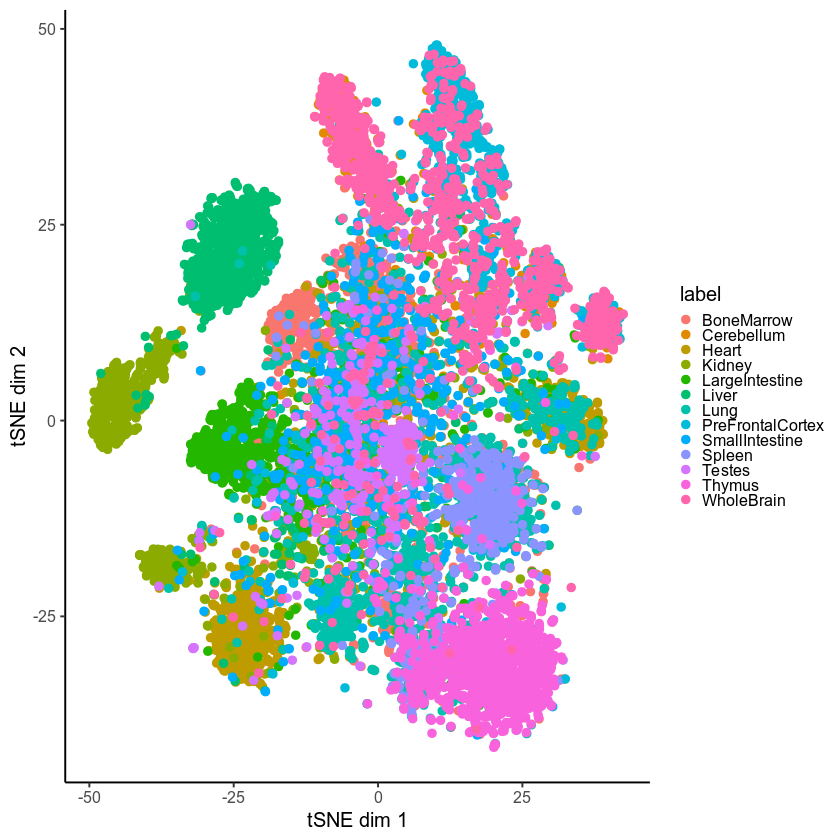

In [45]:
tsne_plots <- plotDeviationsTsne(dev, tsne_results, 
                                 sample_column = "label", 
                                 shiny = FALSE)
tsne_plots[[1]]

In [46]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_chromVAR/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm9_1.4.0 BSgenome_1.50.0                  
 [3] rtracklayer_1.42.1                Biostrings_2.50.2                
 [5] XVector_0.22.0                    JASPAR2016_1.10.0                
 [7] SummarizedExperiment_1.12.0 

In [52]:
save.image(file = 'chromVAR_cusanovich2018subset_motifs.RData')